In [1]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

In [2]:
import io
import textwrap

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib_venn import venn3

from evallm.experiments.transducer_summary import prompt_by_key as prompts_t
from evallm.experiments.sequence_completion_summary import (
    current_setting as current_setting_s,
)

from evallm.experiments.exhaustive_transducer_experiment import (
    run_experiment_for_dfa,
    compute_ngram_each,
)

from evallm.enumerate_dfa.pack_dfa import pack_dfa  # , unpack_dfa

from evallm.experiments.example import (
    transducer_example_csv,
    plot_errors,
    generate_data_for_dfa,
    qualitative_results_table,
)

In [3]:
sum_dfa, _ = generate_data_for_dfa(lambda a, b: (a + b) % 3, current_setting_s)

In [4]:
res_claude_t = run_experiment_for_dfa(
    prompts_t["Red-Green"]["chat"],
    pack_dfa(sum_dfa),
    1000,
    "claude-3-5-sonnet-20241022",
    0,
    keep_completions=True,
)

In [5]:
res_qwen_t = run_experiment_for_dfa(
    prompts_t["Basic"]["non-chat"],
    pack_dfa(sum_dfa),
    1000,
    "Qwen/Qwen2.5-Coder-7B-Instruct",
    0,
)

In [6]:
transducer_masks = {
    "CR": res_claude_t.accuracy_each,
    "QB": res_qwen_t.accuracy_each,
    "6gram": compute_ngram_each(res_qwen_t)[:, 6 - 2],
}

In [7]:
transducer_trivial_cases = (res_claude_t.inputs_packed[:, -1] == 0) | (
    res_claude_t.outputs_packed[:, -2] == 1
)

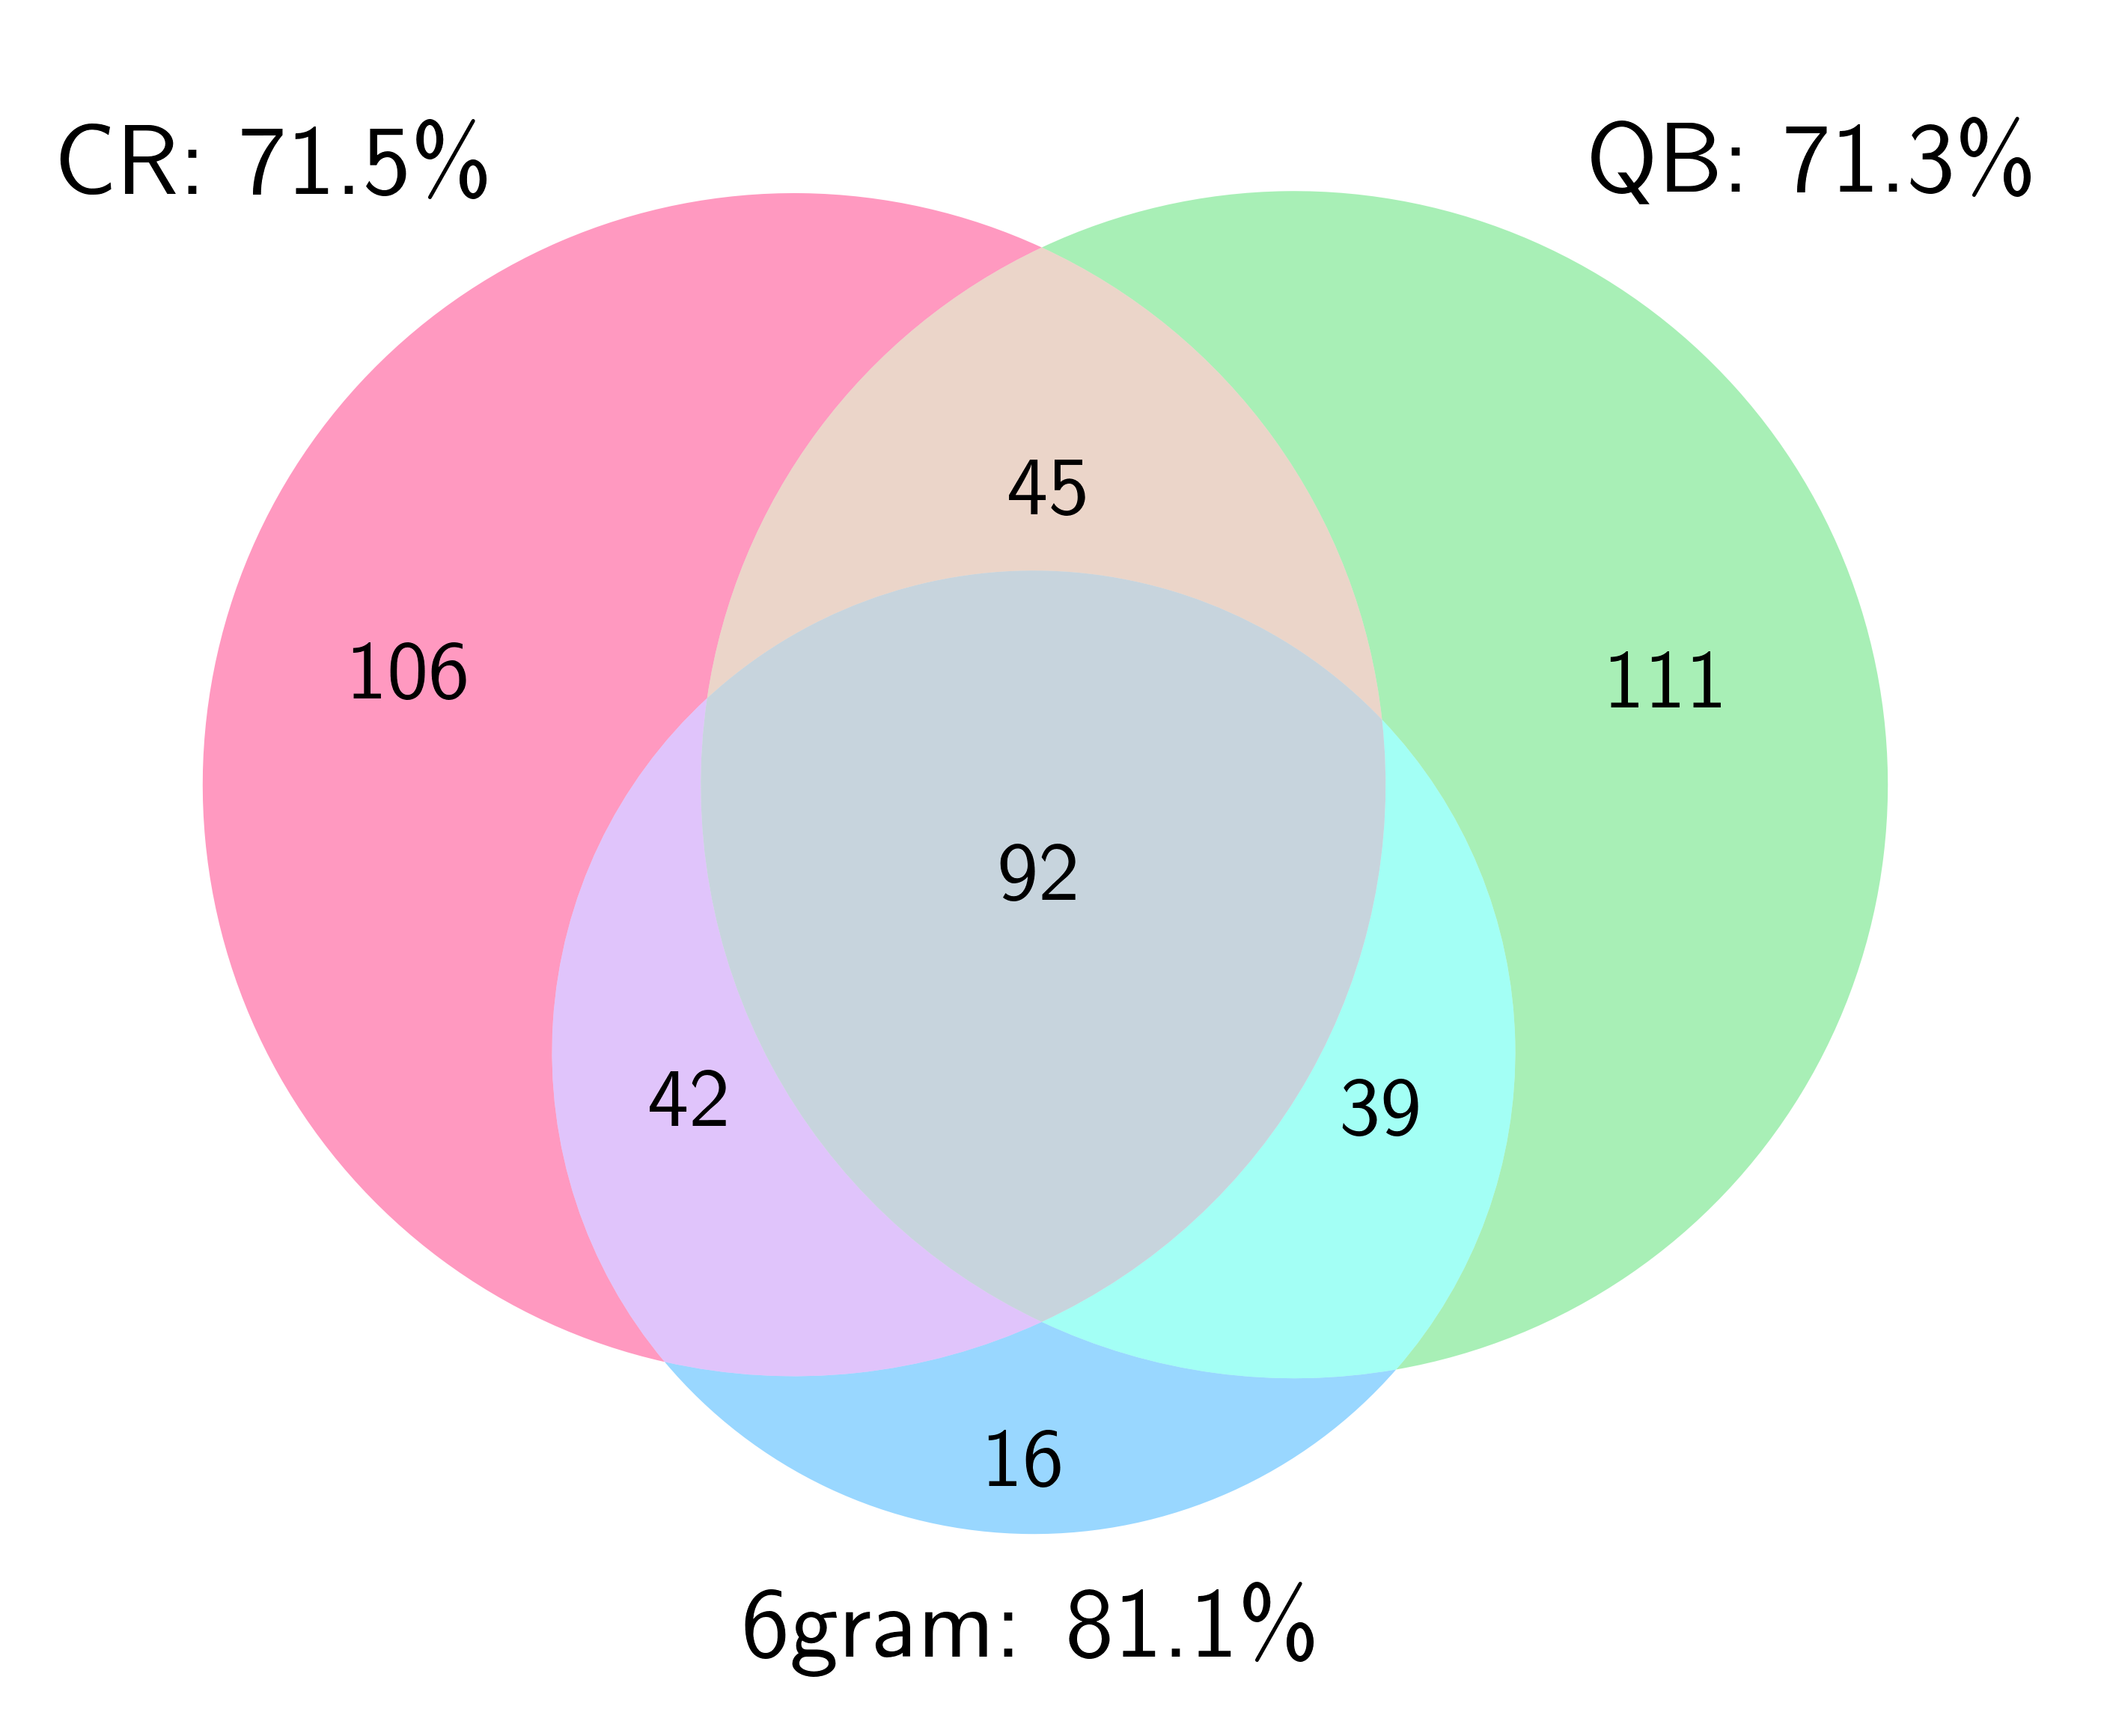

In [8]:
plt.figure(tight_layout=True, dpi=800, figsize=(4.5, 3))
plot_errors(transducer_masks)
plt.savefig("../output/example_dfa/sum_dfa_transducer_error.png", dpi=800)

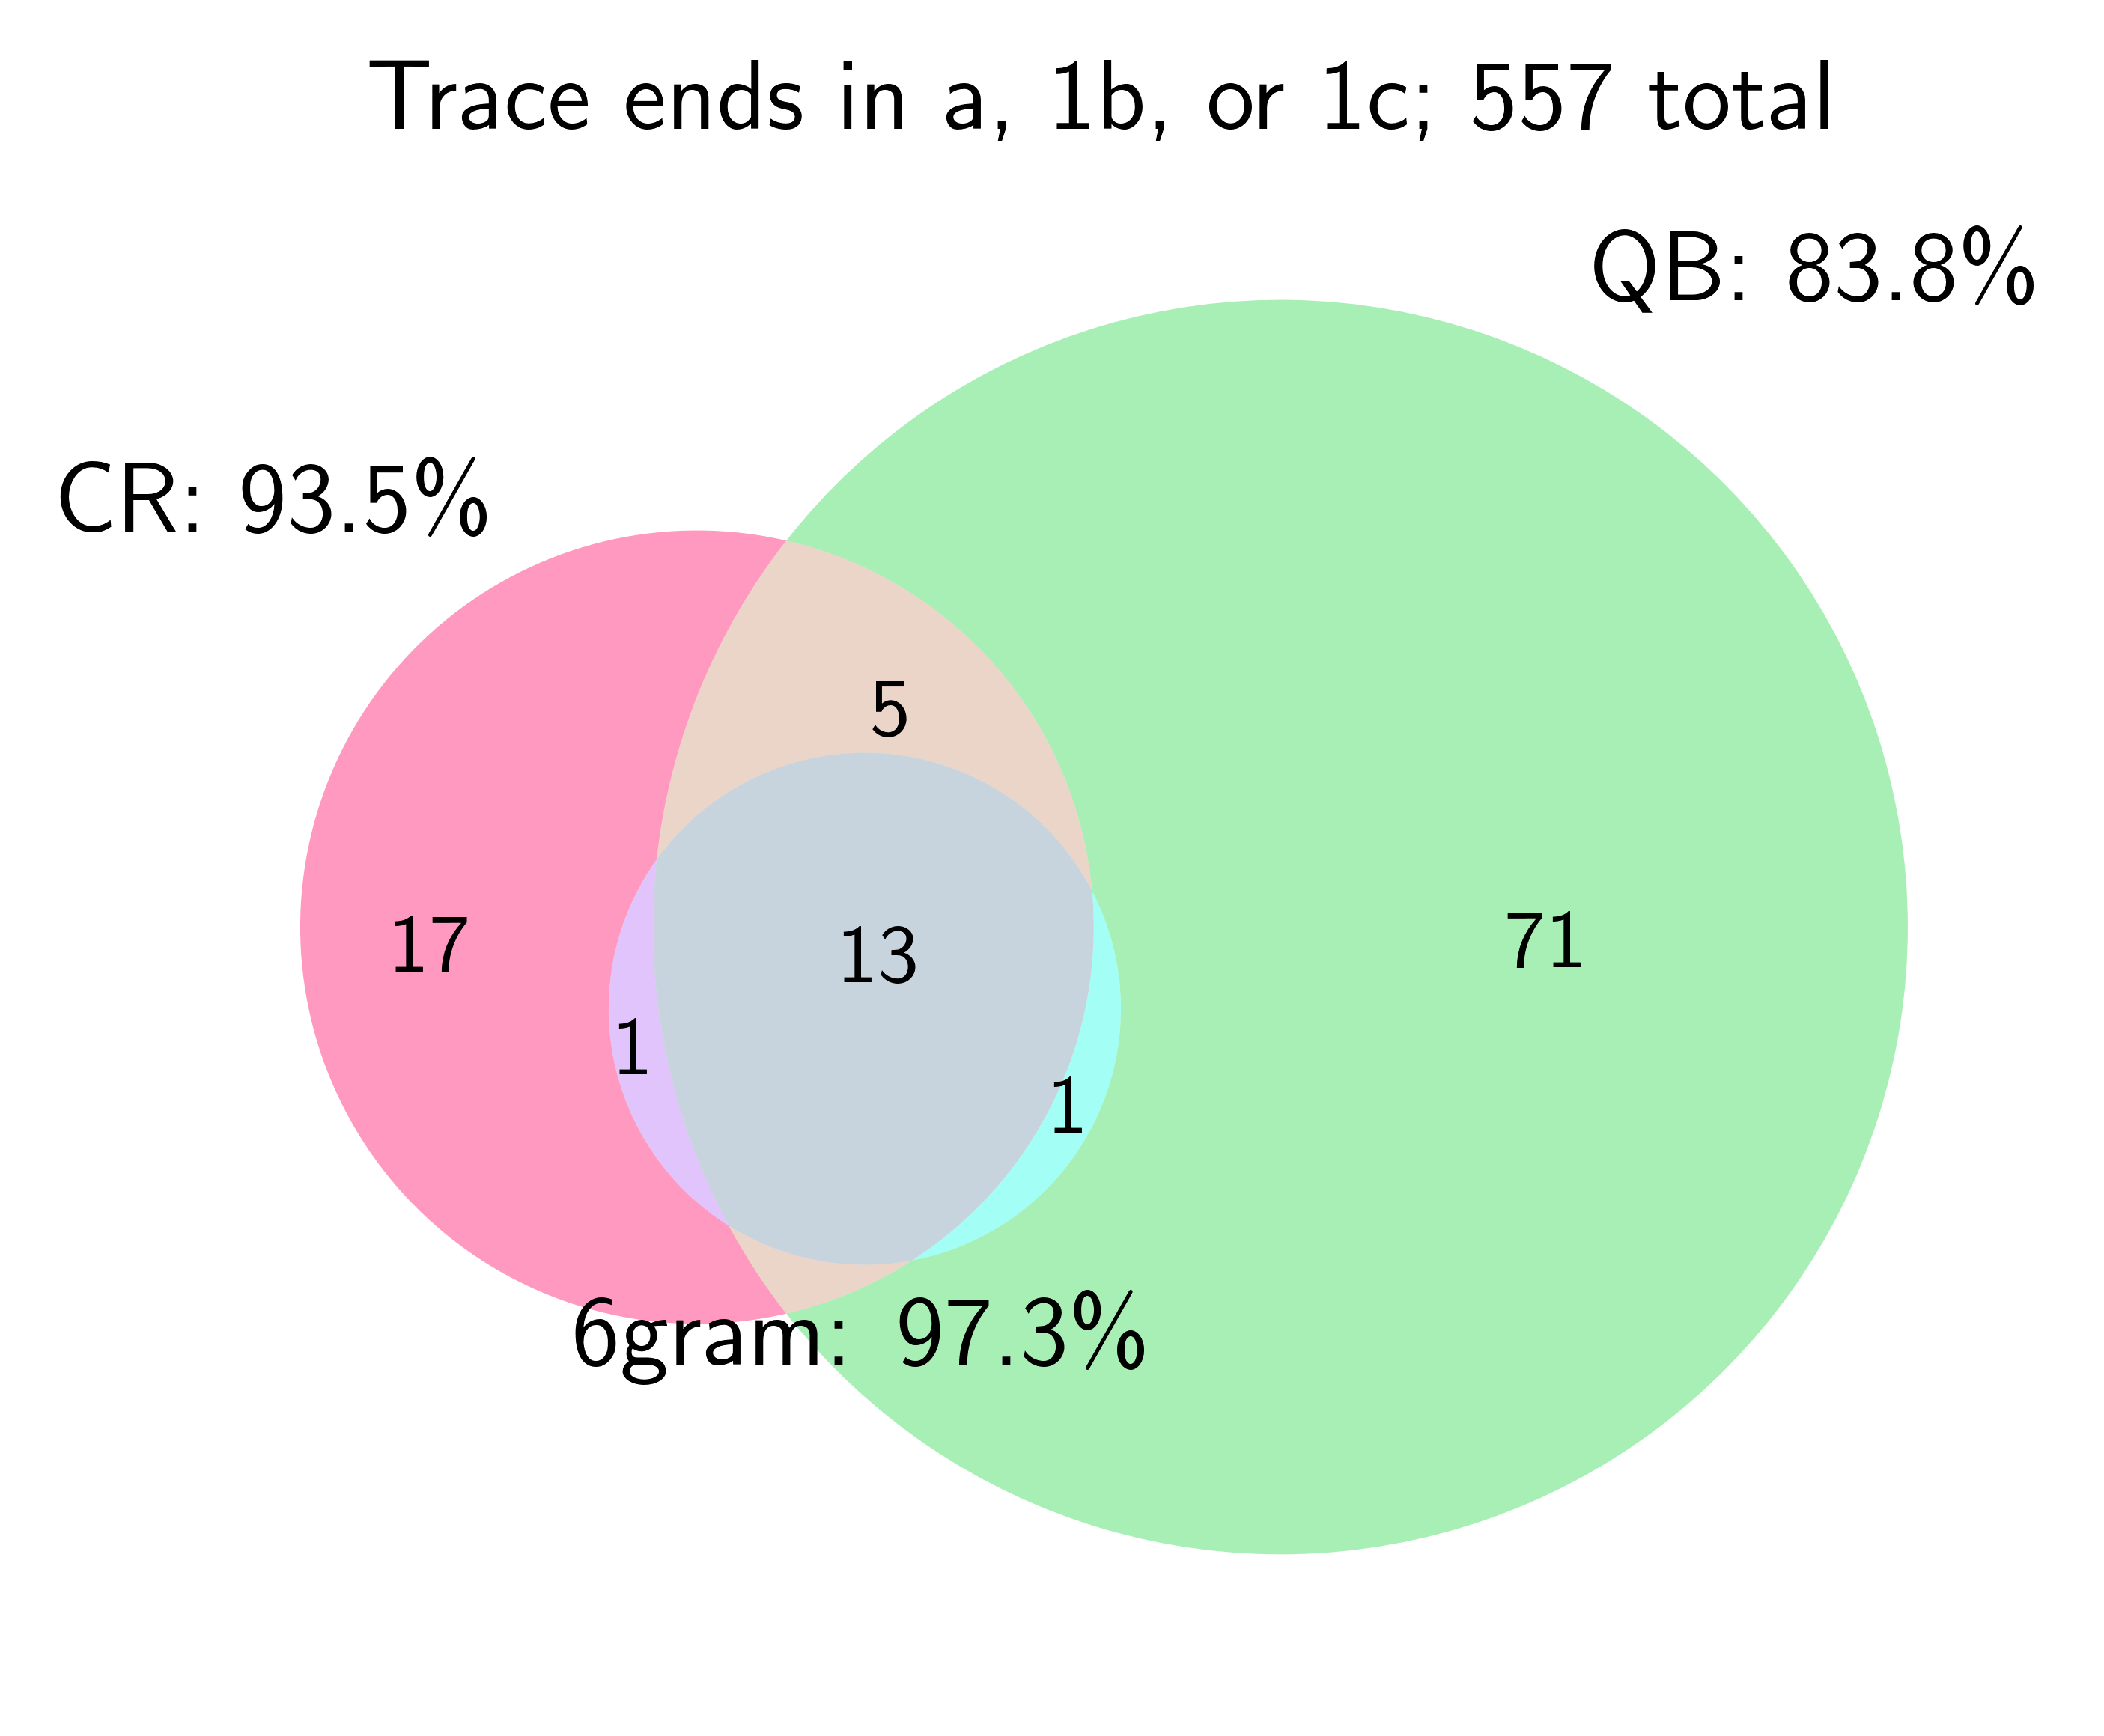

In [9]:
plt.figure(tight_layout=True, dpi=800, figsize=(4.5, 3))
plot_errors({k: v[transducer_trivial_cases] for k, v in transducer_masks.items()})
plt.title(f"Trace ends in a, 1b, or 1c; {transducer_trivial_cases.sum()} total")
plt.savefig("../output/example_dfa/sum_dfa_transducer_error_trivial.png", dpi=800)

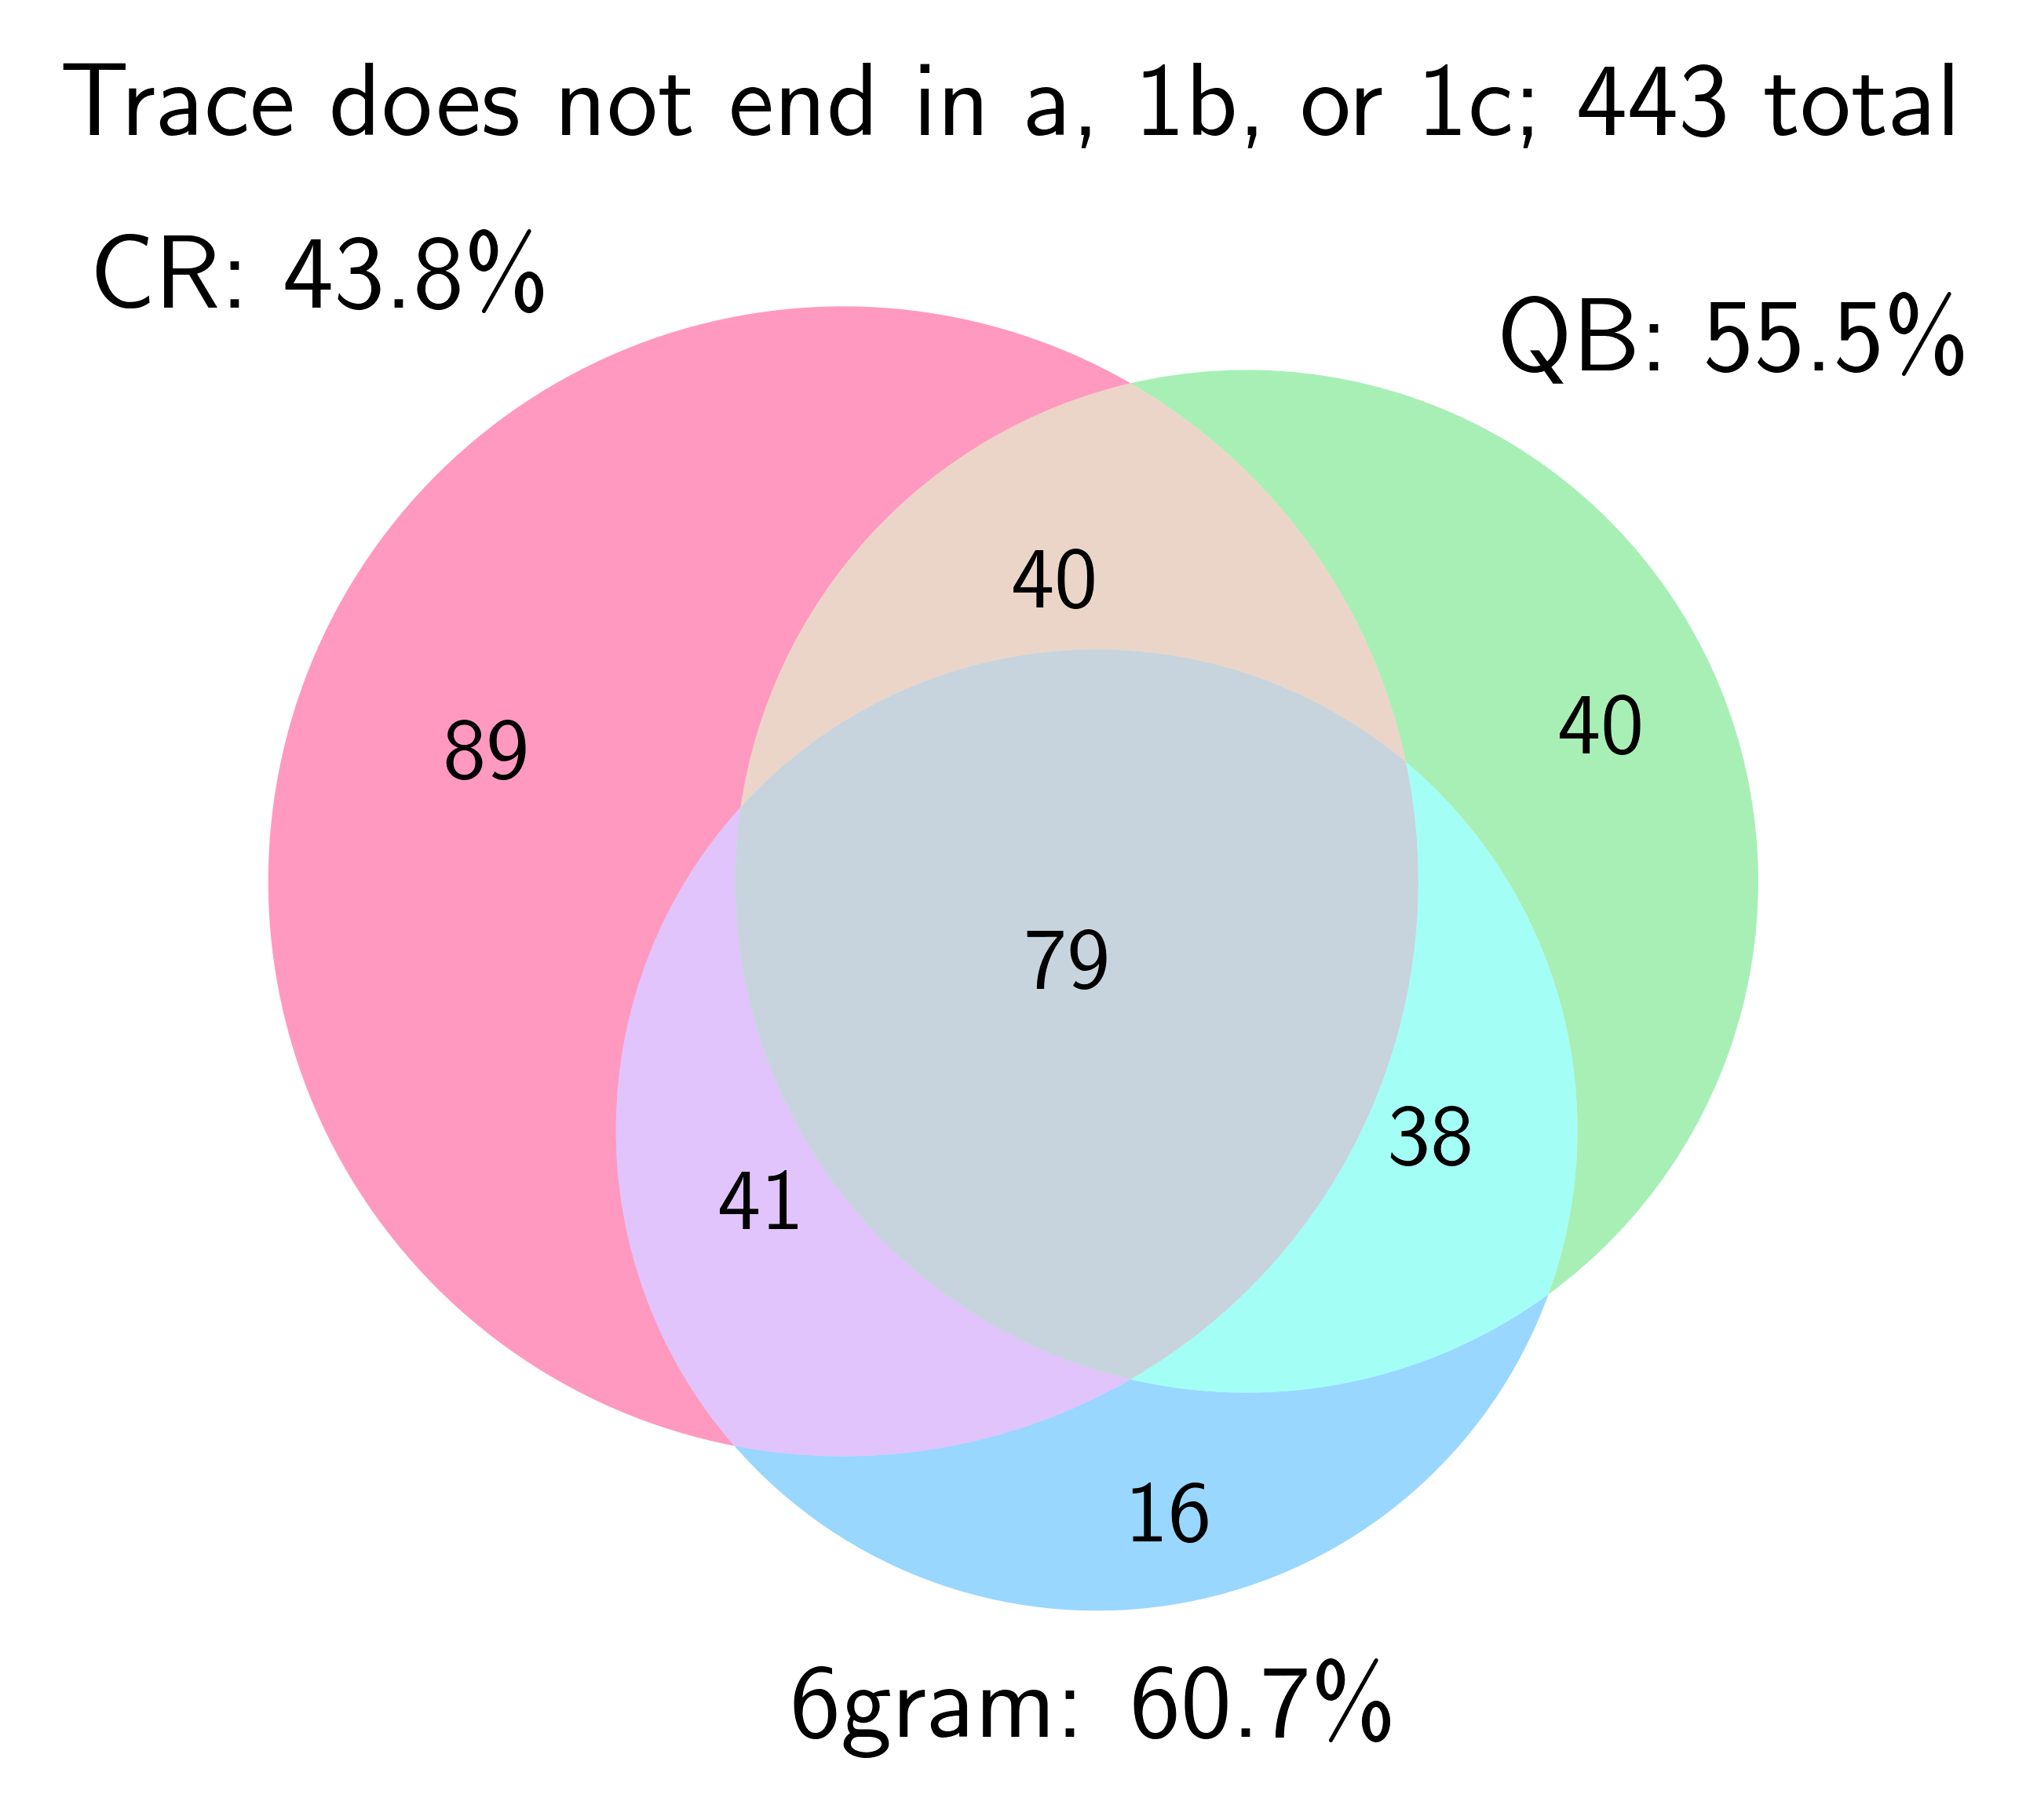

In [10]:
plt.figure(tight_layout=True, dpi=800, figsize=(4.5, 3))
plot_errors({k: v[~transducer_trivial_cases] for k, v in transducer_masks.items()})
plt.title(
    f"Trace does not end in a, 1b, or 1c; {(~transducer_trivial_cases).sum()} total"
)
plt.savefig("../output/example_dfa/sum_dfa_transducer_error_nontrivial.png", dpi=800)

In [11]:
def random_samples_each(masks, size=30):
    rng = np.random.RandomState(0)
    return {k: rng.choice(np.where(masks[k])[0], size=size) for k in masks}

In [12]:
masks_t = {
    "claude-correct": transducer_masks["CR"] == 1,
    "claude-incorrect-6gram-correct": (transducer_masks["CR"] == 0)
    & (transducer_masks["6gram"] == 1),
}
samples_t = random_samples_each(masks_t)

In [13]:
! mkdir -p ../output/example_dfa

In [14]:
claude_reasoning_traces = [x.message.content.lower() for x in res_claude_t.completions]
[x for x in claude_reasoning_traces if "sum" in x or "mod" in x]

["let me analyze the pattern in your movements:\n\ni notice a repeating sequence early on:\nb->red, a->red, c->green\n\nthis sequence repeats exactly 4 times at the start, suggesting you were cycling through the same rooms using the same portals.\n\nlater, there are sequences like:\na->green, a->green showing that some room has an a portal that leads to itself (assuming it's a green room)\n\nlooking at the final sequence:\nb->red, b->red, a->red, a->???\n\nsince we see b->red twice in a row, we must be in a room where portal b leads to itself (in a red room). then taking portal a from that red room leads to another red room. taking a again from that red room should follow the same pattern we've seen before.\n\nbased on the patterns observed, when you take portal a from this red room, you should end up in a red room again.\n\n<answer>red</answer>"]

In [15]:
transducer_example_csv(res_claude_t, samples_t).to_csv(
    "../output/example_dfa/transducer_claude_sample.csv"
)

In [16]:
# Output taken from Qualitative Analysis notebook
qualitatives = r"""
	Total	\texttt{a} is no-op	\texttt{1b} and \texttt{1c} lead to 0	2 red rooms	2-periodic	3-periodic	$>3$-\textsc{Gram}	Sum Modulo 3	\texttt{b} and \texttt{c} cancel
Correct	30	21	14	2	9	4	4	0	0
Incorrect	30	22	17	3	14	4	5	0	1
"""
qualitatives = pd.read_csv(io.StringIO(qualitatives), sep="\t").T
qualitatives.columns = qualitatives.iloc[0]
qualitatives = qualitatives[1:-1]
qualitatives = qualitatives.reset_index()
qualitatives.columns = ["", *qualitatives.columns[1:]]

In [17]:
qualitatives

,,Correct,Incorrect
0,Total,30,30
1,\texttt{a} is no-op,21,22
2,\texttt{1b} and \texttt{1c} lead to 0,14,17
3,2 red rooms,2,3
4,2-periodic,9,14
5,3-periodic,4,4
6,$>3$-\textsc{Gram},4,5
7,Sum Modulo 3,0,0


In [18]:
def figure_minipage(name, path):
    return textwrap.dedent(
        r"""
    \begin{minipage}[t]{0.1\linewidth}
    {\Large ($1)}
    \end{minipage}
    \begin{minipage}{0.8\linewidth}
    \includegraphics[width=\linewidth]{figures/$2}
    \end{minipage}\\
    """.replace(
            "$1", name
        ).replace(
            "$2", path
        )
    )

In [19]:
figure = ""
figure += figure_minipage("a", "sum_dfa_transducer_error.png")
figure += r"""
\begin{minipage}[t]{0.1\linewidth}
{\Large (b)}
\end{minipage}
\begin{minipage}{0.8\linewidth}
"""
figure += qualitative_results_table(qualitatives)
figure += "\end{minipage}"

In [20]:
print(figure)


\begin{minipage}[t]{0.1\linewidth}
{\Large (a)}
\end{minipage}
\begin{minipage}{0.8\linewidth}
\includegraphics[width=\linewidth]{figures/sum_dfa_transducer_error.png}
\end{minipage}\\

\begin{minipage}[t]{0.1\linewidth}
{\Large (b)}
\end{minipage}
\begin{minipage}{0.8\linewidth}
\begin{tabular}{|r|r|r|}
\hline
 & Correct & Incorrect \\\hline
Total & 30 & 30 \\
\hline
\texttt{a} is no-op & 21 & 22 \\
\hline
\texttt{1b} and \texttt{1c} lead to 0 & 14 & 17 \\
\hline
2 red rooms & 2 & 3 \\
\hline
2-periodic & 9 & 14 \\
\hline
3-periodic & 4 & 4 \\
\hline
$>3$-\textsc{Gram} & 4 & 5 \\
\hline
Sum Modulo 3 & 0 & 0 \\
\hline
\end{tabular}
\end{minipage}


In [21]:
print(figure_minipage("a", "sum_dfa_transducer_error_trivial.png"))
print(figure_minipage("b", "sum_dfa_transducer_error_nontrivial.png"))


\begin{minipage}[t]{0.1\linewidth}
{\Large (a)}
\end{minipage}
\begin{minipage}{0.8\linewidth}
\includegraphics[width=\linewidth]{figures/sum_dfa_transducer_error_trivial.png}
\end{minipage}\\


\begin{minipage}[t]{0.1\linewidth}
{\Large (b)}
\end{minipage}
\begin{minipage}{0.8\linewidth}
\includegraphics[width=\linewidth]{figures/sum_dfa_transducer_error_nontrivial.png}
\end{minipage}\\

